In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import adjusted_rand_score, silhouette_score

from src import akeneo, akeneo_clustering as ac, clustering, config

In [3]:
cache = akeneo.create_cache_from_env()

In [4]:
data_dir = config.dir_data / "clustering-results" / "1-cases"
data_dir.mkdir(parents=True, exist_ok=True)

In [5]:
family = "mobile_phone_cases"
channel = "default"
lang = "en_US"

In [6]:
products = ac.parse_products(
    cache,
    product_families=[family],
    attribute_types=ac.TYPES_NUMERICAL + ac.TYPES_CATEGORICAL + ac.TYPES_MULTI + ac.TYPES_TEXT,
)
products_multi_as_single = ac.transform_multi_to_single_cat(products)

products_df = pd.DataFrame(products)
products_multi_as_single_df = pd.DataFrame(products_multi_as_single)

In [7]:
labels_want_generations = products_df["__categories__"].map(lambda x: x[-1].split("_")[0]).to_numpy()
k_generations = len(set(labels_want_generations))
pd.Series(labels_want_generations).value_counts(), f"k = {k_generations}"

(s20    45
 s21    31
 s22     4
 dtype: int64,
 'k = 3')

In [8]:
labels_want_models = products_df["__categories__"].map(lambda x: x[-1]).to_numpy()
k_models = len(set(labels_want_models))
pd.Series(labels_want_models).value_counts(), f"k = {k_models}"

(s20          18
 s20_plus     14
 s21          11
 s20_ultra    11
 s21_plus     10
 s21_fe        5
 s21_ultra     5
 s20_fe        2
 s22           2
 s22_ultra     1
 s22_plus      1
 dtype: int64,
 'k = 11')

In [9]:
attr_metrics = {
    "code": [],
    "name": [],
    "type": [],
    "typeclass": [],
    "required": [],
    "non-null": [],
    "unique": [],
}

req_attr = list(filter(lambda f: f.code == family, cache.families))[0].attribute_requirements[channel]

for attr_code, attr in akeneo.Attribute.to_dict(cache.attributes).items():
    if attr_code not in products_df.columns:
        continue

    typeclass = (
        "numerical"
        if attr.type in ac.TYPES_NUMERICAL
        else "categorical"
        if attr.type in ac.TYPES_CATEGORICAL
        else "multi"
        if attr.type in ac.TYPES_MULTI
        else "string"
        if attr.type in ac.TYPES_TEXT
        else "unknown"
    )

    attr_metrics["code"].append(attr_code)
    attr_metrics["name"].append(attr.labels[lang])
    attr_metrics["type"].append(attr.type)
    attr_metrics["typeclass"].append(typeclass)
    attr_metrics["required"].append(attr_code in req_attr)
    attr_metrics["non-null"].append(products_df[attr_code].count())
    attr_metrics["unique"].append(products_df[attr_code].drop_duplicates().count())

attr_df = pd.DataFrame(attr_metrics)
attr_df.sort_values(["required", "non-null"], ascending=[False, False])

,code,name,type,typeclass,required,non-null,unique
17,icecat_brand,Brand,AttributeType.TEXT,string,True,80,4
19,icecat_name,Name,AttributeType.TEXT,string,True,80,58
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80
11,icecat_8156,Brand compatibility,AttributeType.SELECT_SINGLE,categorical,True,79,1
18,icecat_description_short,Short Description,AttributeType.TEXT,string,True,77,59
9,icecat_6767,Maximum screen size,AttributeType.METRIC,numerical,True,76,7
13,icecat_8778,Case type,AttributeType.SELECT_SINGLE,categorical,True,76,3
14,icecat_898_fixed,Material,AttributeType.SELECT_MULTI,multi,True,57,10
12,icecat_8411,Surface coloration,AttributeType.SELECT_SINGLE,categorical,False,76,2


In [10]:
def calc_metrics(attr_codes, multi_as_single=False, attr_to_overweight: list[str] = None, factor = 2):
    dataset = (
        ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
        if not multi_as_single
        else ac.dataset_from_records(products_multi_as_single_df[attr_codes].to_dict("records"))
    )
    prox_matrix = ac.calc_proximity_matrix(dataset)

    if attr_to_overweight is not None:
        dataset = ac.overweight_attributes(dataset, attr_to_overweight, factor)

    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
    biks = [
        clustering.BisectingKMeans(dataset, ac.Centroid, random_state=i)
        for i in range(1, 11)
    ]

    stabilities = []
    for k in range(2, len(dataset) + 1):
        values = []
        for bikk in biks:
            values.append(
                adjusted_rand_score(
                    bik.labels_flat(k),
                    bikk.labels_flat(k),
                )
            )
        stabilities.append(np.array(values).mean())
    stabilities = np.array(stabilities)

    qualities = []
    for k in range(2, len(dataset)):
        qualities.append(silhouette_score(prox_matrix, bik.labels_flat(k), metric="precomputed"))
    qualities = np.array(qualities)

    return {
        "stabilities": stabilities,
        "qualities": qualities,
        "match_gen": adjusted_rand_score(labels_want_generations, bik.labels_flat(k_generations)),
        "match_mod": adjusted_rand_score(labels_want_models, bik.labels_flat(k_models)),
    }

In [33]:
def metrics_to_table(metric):
    matches = {
        "Match Generations": metric["match_gen"],
        "Match Models": metric["match_mod"],
    }
    result = {
        "Stability": metric["stabilities"].mean(),
        "Quality": metric["qualities"].mean(),
        "Match": np.array([v for _, v in matches.items()]).mean(),
    }
    return {
        "Mean": np.array([v for _, v in result.items()]).mean(),
        **result,
        **matches,
    }

In [12]:
def attr_metrics_make():
    attr_metrics = {}
    for attr_code in attr_df["code"].to_list():
        m = calc_metrics([attr_code])
        attr_metrics[attr_code] = metrics_to_table(m)
    return attr_metrics
attr_metrics = config.load_or_create(data_dir / "attr-metrics.pkl", attr_metrics_make)

In [13]:
attr_metrics_df = pd.DataFrame(attr_metrics).transpose()
attr_metrics_df = attr_metrics_df.round(2) * 100
attr_metrics_df = pd.merge(attr_df, attr_metrics_df.reset_index().rename({"index": "code"}, axis=1), on="code")
attr_metrics_df.sort_values("Stability", ascending=False)

,code,name,type,typeclass,required,non-null,unique,Stability,Quality,Match Generations,Match Models
9,icecat_6767,Maximum screen size,AttributeType.METRIC,numerical,True,76,7,79.0,43.0,10.0,61.0
18,icecat_description_short,Short Description,AttributeType.TEXT,string,True,77,59,73.0,36.0,5.0,18.0
14,icecat_898_fixed,Material,AttributeType.SELECT_MULTI,multi,True,57,10,71.0,44.0,2.0,4.0
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80,60.0,16.0,100.0,49.0
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80,59.0,15.0,5.0,22.0
19,icecat_name,Name,AttributeType.TEXT,string,True,80,58,58.0,33.0,3.0,4.0
0,icecat_1464,Height,AttributeType.METRIC,numerical,False,24,11,56.0,32.0,4.0,2.0
2,icecat_1649,Width,AttributeType.METRIC,numerical,False,24,12,55.0,34.0,4.0,2.0
15,icecat_94,Weight,AttributeType.METRIC,numerical,False,24,11,53.0,33.0,4.0,1.0
3,icecat_1650,Depth,AttributeType.METRIC,numerical,False,24,11,51.0,31.0,4.0,2.0


In [14]:
level = 20
attr_metrics_df[
    (attr_metrics_df["Match Generations"] > level) |
    (attr_metrics_df["Match Models"] > level)
]

,code,name,type,typeclass,required,non-null,unique,Stability,Quality,Match Generations,Match Models
8,icecat_4860,Desktop stand,AttributeType.BOOL,categorical,False,58,2,47.0,25.0,31.0,9.0
9,icecat_6767,Maximum screen size,AttributeType.METRIC,numerical,True,76,7,79.0,43.0,10.0,61.0
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80,60.0,16.0,100.0,49.0
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80,59.0,15.0,5.0,22.0


In [15]:
attr_codes_impact = ["icecat_4860", "icecat_6767", "icecat_summary_short", "icecat_title"]
attr_codes_intuitive = ["icecat_6767", "icecat_title", "icecat_1464", "icecat_1649", "icecat_1650"]
attr_codes_intuitive_plus = attr_codes_intuitive + ["icecat_8778", "icecat_8156"]

### Eval Multi-Categorical

In [16]:
def mul_metrics_make():
    str_codes = ["icecat_brand", "icecat_name", "icecat_title", "icecat_description_short", "icecat_summary_short"]
    return {
        "multi": calc_metrics(["icecat_898_fixed"]),
        "multi as single": calc_metrics(["icecat_898_fixed"], True),
        "string as multi": calc_metrics(str_codes),
        "string as single": calc_metrics(str_codes, True),
    }
mul_metrics = config.load_or_create(data_dir / "mul-metrics.pkl", mul_metrics_make)

<AxesSubplot:title={'center':'Clustering-Metrics'}>

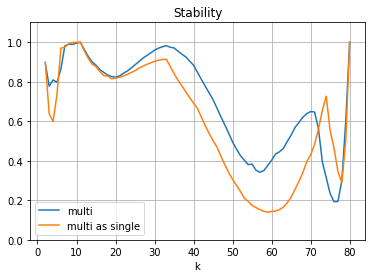

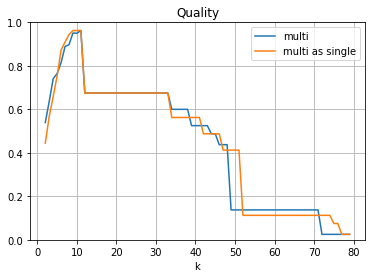

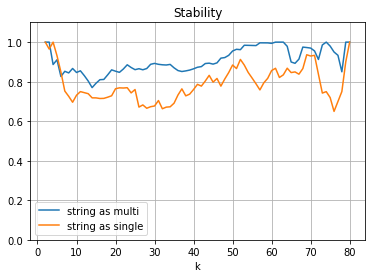

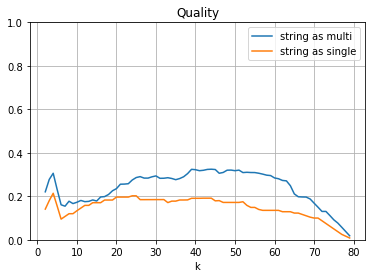

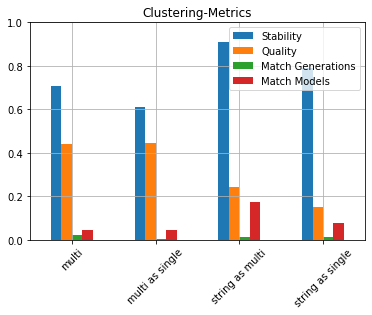

In [17]:
n = len(products)

pd.DataFrame({key: mul_metrics[key]["stabilities"] for key in ["multi", "multi as single"]}, index=range(2,n+1)).plot.line(title="Stability", xlabel="k", ylim=(0,1.1), grid=True)
pd.DataFrame({key: mul_metrics[key]["qualities"] for key in ["multi", "multi as single"]}, index=range(2,n)).plot.line(title="Quality", xlabel="k", ylim=(0,1), grid=True)

pd.DataFrame({key: mul_metrics[key]["stabilities"] for key in ["string as multi", "string as single"]}, index=range(2,n+1)).plot.line(title="Stability", xlabel="k", ylim=(0,1.1), grid=True)
pd.DataFrame({key: mul_metrics[key]["qualities"] for key in ["string as multi", "string as single"]}, index=range(2,n)).plot.line(title="Quality", xlabel="k", ylim=(0,1), grid=True)

pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in mul_metrics.items()
}).transpose().plot.bar(title="Clustering-Metrics", ylim=(0,1), grid=True, rot=45)

In [18]:
case_to_attr = {
    "numerical": attr_df[attr_df["typeclass"]=="numerical"]["code"].to_list(),
    "categorical": attr_df[attr_df["typeclass"]=="categorical"]["code"].to_list(),
    "multi": attr_df[attr_df["typeclass"]=="multi"]["code"].to_list(),
    "string": attr_df[attr_df["typeclass"]=="string"]["code"].to_list(),
    "num+cat": attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])]["code"].to_list(),
    "num+cat+mul": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi"])]["code"].to_list(),
    "num+cat+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "string"])]["code"].to_list(),
    "num+cat+mul+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi", "string"])]["code"].to_list(),
    "numerical req": attr_df[(attr_df["typeclass"]=="numerical")&attr_df["required"]]["code"].to_list(),
    "categorical req": attr_df[(attr_df["typeclass"]=="categorical")&attr_df["required"]]["code"].to_list(),
    "num+cat req": attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])&attr_df["required"]]["code"].to_list(),
    "num+cat+mul req": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi"])&attr_df["required"]]["code"].to_list(),
    "num+cat+str req": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "string"])&attr_df["required"]]["code"].to_list(),
    "num+cat+mul+str req": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi", "string"])&attr_df["required"]]["code"].to_list(),
}
pd.DataFrame([(key, value) for key, value in case_to_attr.items()])

,0,1
0,numerical,"[icecat_1464, icecat_1649, icecat_1650, icecat..."
1,categorical,"[icecat_15767, icecat_26241, icecat_27575_fixe..."
2,multi,[icecat_898_fixed]
3,string,"[icecat_brand, icecat_description_short, iceca..."
4,num+cat,"[icecat_1464, icecat_15767, icecat_1649, iceca..."
5,num+cat+mul,"[icecat_1464, icecat_15767, icecat_1649, iceca..."
6,num+cat+str,"[icecat_1464, icecat_15767, icecat_1649, iceca..."
7,num+cat+mul+str,"[icecat_1464, icecat_15767, icecat_1649, iceca..."
8,numerical req,[icecat_6767]
9,categorical req,"[icecat_8156, icecat_8778]"


In [19]:
def metrics_make():
    metrics = {
        key: calc_metrics(value)
        for key, value in case_to_attr.items()
    }

    all_codes = attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi", "string"])]["code"].to_list()
    codes_num_cat = attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])]["code"].to_list()
    codes_str = attr_df[attr_df["typeclass"].isin(["string"])]["code"].to_list()

    return {
        **metrics,
        "high impact": calc_metrics(attr_codes_impact),
        "all & high impact x2": calc_metrics(all_codes, False, attr_codes_impact, 2),
        "all & high impact x3": calc_metrics(all_codes, False, attr_codes_impact, 3),
        "num+cat & high impact x2": calc_metrics(codes_num_cat, False, attr_codes_impact, 2),
        "num+cat & high impact x3": calc_metrics(codes_num_cat, False, attr_codes_impact, 3),
        "str & high impact x2": calc_metrics(codes_str, False, attr_codes_impact, 2),
        "str & high impact x3": calc_metrics(codes_str, False, attr_codes_impact, 3),
        "intuitive": calc_metrics(attr_codes_intuitive),
        "all & intuitive x2": calc_metrics(all_codes, False, attr_codes_intuitive, 2),
        "all & intuitive x3": calc_metrics(all_codes, False, attr_codes_intuitive, 3),
        "num+cat & intuitive x2": calc_metrics(codes_num_cat, False, attr_codes_intuitive, 2),
        "num+cat & intuitive x3": calc_metrics(codes_num_cat, False, attr_codes_intuitive, 3),
        "str & intuitive x2": calc_metrics(codes_str, False, attr_codes_intuitive, 2),
        "str & intuitive x3": calc_metrics(codes_str, False, attr_codes_intuitive, 3),
        "intuitive+": calc_metrics(attr_codes_intuitive_plus),
        "all & intuitive+ x2": calc_metrics(all_codes, False, attr_codes_intuitive_plus, 2),
        "all & intuitive+ x3": calc_metrics(all_codes, False, attr_codes_intuitive_plus, 3),
        "num+cat & intuitive+ x2": calc_metrics(codes_num_cat, False, attr_codes_intuitive_plus, 2),
        "num+cat & intuitive+ x3": calc_metrics(codes_num_cat, False, attr_codes_intuitive_plus, 3),
        "str & intuitive+ x2": calc_metrics(codes_str, False, attr_codes_intuitive_plus, 2),
        "str & intuitive+ x3": calc_metrics(codes_str, False, attr_codes_intuitive_plus, 3),
    }
metrics = config.load_or_create(data_dir / "metrics.pkl", metrics_make)

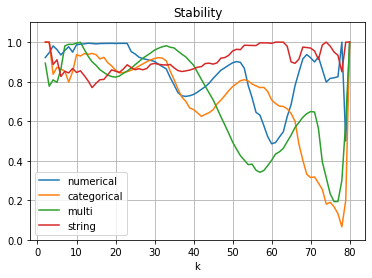

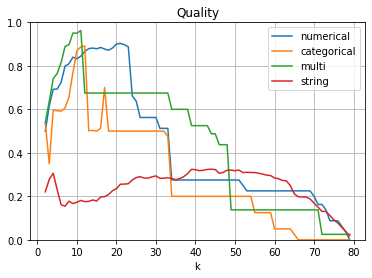

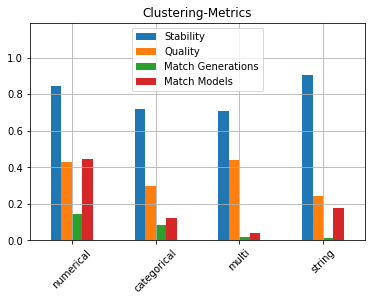

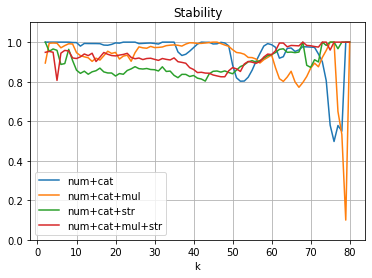

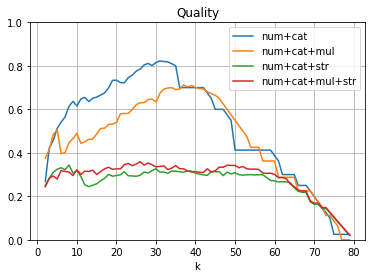

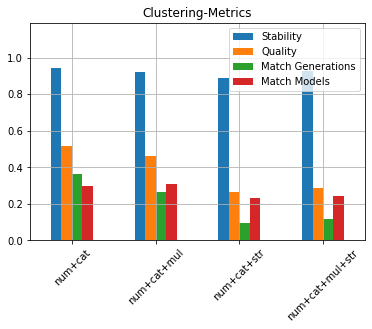

In [25]:
keys_display = [
    ["numerical", "categorical", "multi", "string"],
    ["num+cat", "num+cat+mul", "num+cat+str", "num+cat+mul+str"],
]
for keys in keys_display:
    stabs = {key: metrics[key]["stabilities"] for key in keys}
    quals = {key: metrics[key]["qualities"] for key in keys}
    metrs = {key: metrics[key] for key in keys}
    pd.DataFrame(stabs, index=range(2,n+1)).plot.line(title="Stability", xlabel="k", ylim=(0,1.1), grid=True)
    pd.DataFrame(quals, index=range(2,n)).plot.line(title="Quality", xlabel="k", ylim=(0,1), grid=True)
    pd.DataFrame({
        key: metrics_to_table(values)
        for key, values in metrs.items()
    }).transpose().plot.bar(title="Clustering-Metrics", ylim=(0,1.19), grid=True, rot=45)

In [35]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics.items()
}).transpose().round(2).sort_values("Mean", ascending=False)

,Mean,Stability,Quality,Match,Match Generations,Match Models
num+cat,0.60,0.95,0.52,0.33,0.36,0.30
num+cat+mul,0.56,0.92,0.46,0.29,0.26,0.31
num+cat & high impact x2,0.55,0.81,0.49,0.34,0.36,0.32
num+cat & intuitive x2,0.54,0.84,0.51,0.29,0.26,0.31
numerical req,0.53,0.79,0.43,0.35,0.10,0.61
numerical,0.53,0.85,0.43,0.30,0.15,0.45
num+cat & intuitive x3,0.51,0.82,0.47,0.23,0.15,0.31
num+cat & high impact x3,0.51,0.83,0.48,0.21,0.13,0.29
num+cat & intuitive+ x3,0.50,0.83,0.48,0.20,0.12,0.28
num+cat & intuitive+ x2,0.49,0.80,0.47,0.20,0.13,0.28
